<a href="https://colab.research.google.com/github/dvd30/100-Problems/blob/main/Face-Detection-Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

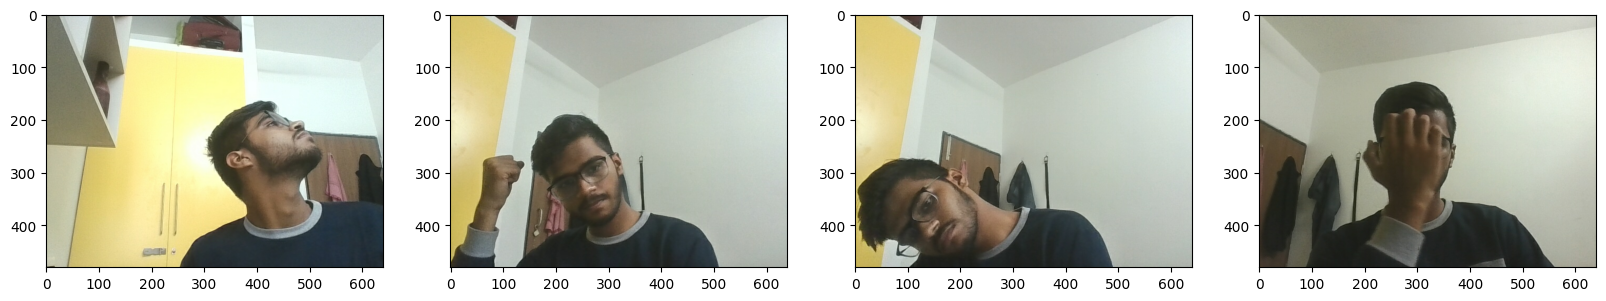

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

def disp_img(img):
    img_generator = img.batch(4).as_numpy_iterator()
    plot_img = img_generator.next()
    fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
    for idx, images in enumerate(plot_img):
        ax[idx].imshow(images)
    plt.show()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
images = tf.data.Dataset.list_files("data/images/*.jpg", shuffle=True)
def load_img(img):
    byte_img = tf.io.read_file(img)
    im = tf.io.decode_jpeg(byte_img)
    return im
images = images.map(load_img)
disp_img(images)

In [2]:
import os
import shutil
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
      filename = file.split('.')[0]+'.json'
      current_path = os.path.join('data', 'labels', filename)
      if os.path.exists(current_path):
          new_path = os.path.join('data', folder, 'labels')
          shutil.move(current_path, new_path)

In [3]:
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(450, 450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomGamma(p=0.2),
                         alb.VerticalFlip(p=0.5),
                         alb.RGBShift(p=0.2),
                         alb.RandomBrightnessContrast(p=0.2)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))


In [4]:
import cv2
import json
import numpy as np
img = cv2.imread(os.path.join('data', 'train', 'images', '021aed64-91b9-11ee-81e9-141333c4339e.jpg'))
with open(os.path.join('data', 'train', 'labels', '021aed64-91b9-11ee-81e9-141333c4339e.json'), 'r') as f:
  label =json.load(f)
label

{'version': '5.3.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[268.3240223463687, 122.68156424581007],
    [467.7653631284916, 365.1396648044693]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\021aed64-91b9-11ee-81e9-141333c4339e.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRo

In [5]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords = list(np.divide(coords,[640, 480, 640, 480]))
coords

[0.41925628491620104,
 0.25558659217877094,
 0.7308833798882681,
 0.760707635009311]

In [6]:
augmented = augmentor(image = img, bboxes=[coords], class_labels=['face'])

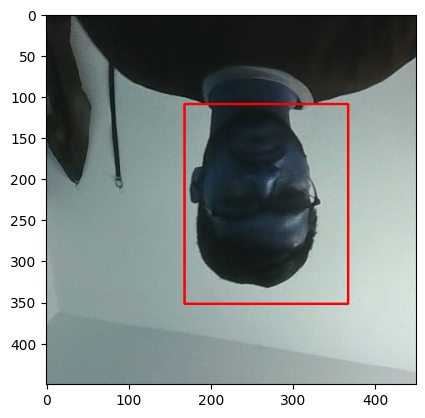

In [7]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

In [8]:
for partition in ['train','test','val']:
  for image in os.listdir(os.path.join('data', partition, 'images')):
    img = cv2.imread(os.path.join('data', partition, 'images', image))
    coords = [0,0,0.00001,0.00001]
    label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)
      if label['shapes'] != []:
        coords[0] = label['shapes'][0]['points'][0][0]
        coords[1] = label['shapes'][0]['points'][0][1]
        coords[2] = label['shapes'][0]['points'][1][0]
        coords[3] = label['shapes'][0]['points'][1][1]
        coords = list(np.divide(coords, [640,480,640,480]))
    try:
      for x in range(60):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
        cv2.imwrite(os.path.join('aug_data', partition, 'images', str(f'{image.split(".")[0]}.{x}.jpg')), augmented['image'])
        annotation = {}
        annotation['image'] = image
        if os.path.exists(label_path):
          if len(augmented['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

      with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
          json.dump(annotation, f)

    except Exception as e:
        print(e)

x_max is less than or equal to x_min for bbox [0.8138093575418994, 0.9888268156424581, 0.3267283519553072, 0.24162011173184358, 'face'].
x_max is less than or equal to x_min for bbox [0.7230272346368715, 0.8514897579143389, 0.3843400837988826, 0.3067970204841713, 'face'].
x_max is less than or equal to x_min for bbox [0.6697800279329608, 0.8479981378026071, 0.34244064245810046, 0.351024208566108, 'face'].
x_max is less than or equal to x_min for bbox [0.5920914804469273, 0.843342644320298, 0.22197974860335196, 0.2718808193668529, 'face'].
x_max is less than or equal to x_min for bbox [0.49345321229050276, 0.9527467411545625, 0.018592877094972017, 0.5139664804469274, 'face'].
x_max is less than or equal to x_min for bbox [0.8068261173184357, 0.7304469273743017, 0.5013093575418994, 0.27886405959031657, 'face'].
x_max is less than or equal to x_min for bbox [0.9691864525139664, 0.8282122905027933, 0.6078037709497206, 0.22648975791433892, 'face'].
x_max is less than or equal to x_min for b

In [9]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [10]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [12]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding='utf-8') as f:
    label = json.load(f)

  return [label['class']], label['bbox']

In [13]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [16]:
len(train_images), len(test_images), len(val_images), len(train_labels), len(test_labels), len(val_labels)

(7140, 1800, 1800, 119, 30, 30)

In [17]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [19]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [22]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)
    ax[idx].imshow(sample_image)

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Add, GlobalMaxPooling2D, Dropout
from tensorflow.keras.applications import VGG16

In [26]:
vgg = VGG16(include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
def build_model():
  input_layer = Input(shape=(120,120,3))
  vgg = VGG16(include_top=False)(input_layer)

  # Classification Model
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1)

  # Bounding box model\n",
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation='relu')(f1)
  regress2 = Dense(4, activation='sigmoid')(regress1)

  facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return facetracker

In [30]:
facetracker = build_model()

In [31]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [81]:
test_samples = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [82]:
classes, coords = facetracker.predict(test_samples[0])

1/1 [==============================] - 2s 2s/step


In [83]:
classes, coords

(array([[0.5538198 ],
        [0.5420863 ],
        [0.5528915 ],
        [0.54734004],
        [0.5861817 ],
        [0.6129491 ],
        [0.5959761 ],
        [0.5205281 ]], dtype=float32),
 array([[0.1539149 , 0.14591882, 0.51779246, 0.52636045],
        [0.15325256, 0.14948694, 0.47376773, 0.49895003],
        [0.15273634, 0.1655832 , 0.43863884, 0.47281867],
        [0.15106311, 0.16895275, 0.43615943, 0.48275024],
        [0.19613083, 0.14413077, 0.53424674, 0.5551813 ],
        [0.15259095, 0.15664646, 0.52080834, 0.54005575],
        [0.17836091, 0.13162485, 0.537706  , 0.56300837],
        [0.1538644 , 0.15574233, 0.45093727, 0.483431  ]], dtype=float32))

In [84]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [85]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum = lr_decay)

In [86]:
def localization_loss(y_true, yhat):
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]
  h_pred = yhat[:,3] - yhat[:,1]
  w_pred = yhat[:,2] - yhat[:,0]
  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
  return delta_coord + delta_size

In [87]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [88]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4373076>

In [89]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6585538>

In [90]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4373076>

In [55]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [56]:
model = FaceTracker(facetracker)

In [57]:
model.compile(opt, classloss, regressloss)

In [58]:
logdir='logs'

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [114]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

In [91]:
hist.history

{'total_loss': [1.566267490386963,
  1.576021671295166,
  1.4093844890594482,
  1.7612993717193604,
  1.259672999382019,
  1.7195552587509155,
  1.779157042503357,
  1.5500444173812866,
  1.603467345237732,
  1.4239332675933838],
 'class_loss': [0.639007031917572,
  0.7259856462478638,
  0.6235769391059875,
  0.6830105185508728,
  0.47860482335090637,
  0.6854874491691589,
  0.6599586606025696,
  0.6709654927253723,
  0.6153220534324646,
  0.6340056657791138],
 'regress_loss': [1.2467639446258545,
  1.213028907775879,
  1.0975960493087769,
  1.4197940826416016,
  1.020370602607727,
  1.3768115043640137,
  1.4491777420043945,
  1.2145617008209229,
  1.2958062887191772,
  1.1069303750991821],
 'val_total_loss': [1.4142309427261353,
  1.7058004140853882,
  1.7583575248718262,
  2.115216016769409,
  1.6544691324234009,
  1.460489273071289,
  2.228705644607544,
  1.3644776344299316,
  1.3821725845336914,
  1.6121697425842285],
 'val_class_loss': [0.6239581108093262,
  0.747205913066864,
  0

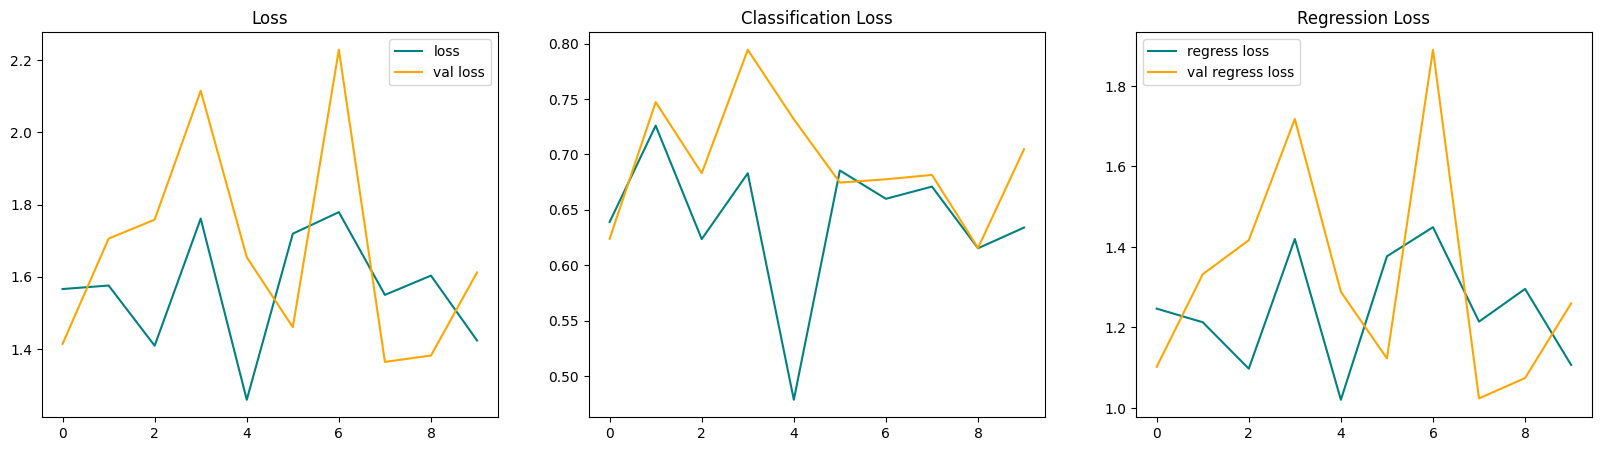

In [92]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [103]:
test_data = test.as_numpy_iterator()

In [107]:
test_sample = test_data.next()

In [109]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


In [109]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)
    ax[idx].imshow(sample_image)

In [110]:
 from tensorflow.keras.models import load_model

In [111]:
facetracker.save('facetracker.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
facetracker = load_model('facetracker.h5')

In [113]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                      (255,0,0), -1)

      # Controls the text rendered\n",
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                              [0,-5])),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    cap.release()
    cv2.destroyAllWindows()